In [260]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\PYWORK\NHITS


In [261]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [ ]:
cutoff_date = '2021-05-31' ## len = 65
test_period = 12

## <원 data set>

In [262]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

raw_y_set_resampled = df
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)

In [ ]:
%%time
raw_y_set_shifted_merged = raw_y_set_resampled.date<=cutoff_date

for i in range(len(raw_y_set_resampled. columns)):
    if i == len (raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(7,15) :
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
raw_y_set_shifted_merged

In [ ]:
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

In [ ]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
raw_y_Sety_shifted_merged_filtered.to_csv('./data/raw_y_set_shifted_merged_filtered_month.csv', encoding='cp949')

#### scasler

In [96]:
df_tgt = df.iloc[:,3:]

scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

#### static DF

In [97]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [98]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [99]:
# len(df.loc[df.ds<'2021-06-30'])

## <기준 날짜 및 예측 기간 설정>

In [231]:
Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<cutoff_date])]] # 132 train
Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]][:test_period]

In [239]:
futr_temp = Y_test_df.drop(['y'], axis=1)
futr_list = [
             'Shanghai Containerized Freight Index (SCFI)',
             '대두 [미국(생산자 가격)] 현물',
             # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
             '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
             # 'HOUSECOST_KOR'
             ]
futr_date = futr_temp.iloc[:,:2]
futr_df = pd.concat([futr_date,futr_temp[futr_list]], axis=1)
# futr_df

In [240]:
Y_hat_df

,ds,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close,NHITS
0,2021-06-30,A,13.340909,-0.544854,1.700096,0.652644,-0.264276,1.388798,0.645708,-0.878008,...,0.357390,0.360366,0.357275,0.083441,0.295629,0.292393,0.301950,0.293123,0.293123,18.900324
1,2021-07-31,A,14.045455,-0.489898,2.001985,1.135170,-0.197342,1.483675,0.744005,-0.774386,...,0.512727,0.529393,0.529656,0.208759,0.519217,0.524612,0.536282,0.534588,0.534588,20.887424
2,2021-08-31,A,14.590909,-0.464069,2.629514,1.687843,-0.078270,1.641803,1.337590,-0.670765,...,1.216152,1.190111,1.218320,0.622869,1.083831,1.090253,1.075285,1.087407,1.087407,23.357975
3,2021-09-30,A,19.083333,-0.280700,3.299182,1.991462,0.100634,0.953946,1.372534,-0.295136,...,1.204125,1.199434,1.197162,0.611440,1.124191,1.123562,1.129411,1.129772,1.129772,15.593801
4,2021-10-31,A,22.750000,-0.096964,3.926870,1.998856,0.187008,0.613970,1.257820,-0.042559,...,1.073697,1.076272,1.073636,0.565137,1.020054,1.006143,1.008416,1.008169,1.008169,15.432747
5,2021-11-30,A,28.170455,0.164625,1.521353,1.794166,0.556798,0.811631,1.318295,0.391356,...,1.456465,1.463497,1.467292,1.031930,1.240984,1.248657,1.253894,1.257281,1.257281,14.732832
6,2021-12-31,A,33.043478,0.286579,1.582281,1.839908,1.084157,0.969759,1.115623,0.520883,...,1.775690,1.776023,1.790538,1.704423,1.185124,1.187299,1.189690,1.197156,1.197156,12.749650
7,2022-01-31,A,43.260870,0.631414,0.318707,1.983558,1.463396,1.048823,0.916574,0.779937,...,2.680955,2.665481,2.680401,2.510212,1.610945,1.608097,1.585530,1.586450,1.586450,10.006703
8,2022-02-28,A,56.425000,1.270279,0.406105,2.294724,1.435042,1.467862,0.798730,1.945680,...,2.207543,2.190755,2.181831,2.058747,1.168835,1.174279,1.163390,1.167415,1.167415,8.637333
9,2022-03-31,A,71.086957,2.126927,1.148209,2.612162,1.241856,1.831557,1.195636,2.269497,...,2.013125,2.037362,2.013198,1.906047,1.471655,1.468981,1.476677,1.477051,1.477051,9.277889


In [241]:
horizon = len(Y_test_df)

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=12, input_size=24,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,  
          #       futr_exog_list = futr_list,
          #       max_steps=100,
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                stat_exog_list = None,
                hist_exog_list=None,
                futr_exog_list = futr_list,
                # n_freq_downsample=[24, 12, 1],
                scaler_type = 'robust',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=64,
                random_seed=42,
                max_epochs=50
               ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=12, 
          #     input_size=5 * horizon,
          #     # hidden_size=20,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = futr_list,
          #     max_steps=100,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df).reset_index()

Epoch 0:  50%|██████████████▌              | 1/2 [00:00<00:00,  2.60it/s, loss=0.113, v_num=945, train_loss_step=0.113]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██▌  | 1/2 [00:00<00:00,  7.94it/s, loss=0.102, v_num=945, train_loss_step=0.092, train_loss_epoch=0.113]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|██  | 1/2 [00:00<00:00,  7.55it/s, loss=0.0956, v_num=945, train_loss_step=0.082, train_loss_epoch=0.092]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|█▌ | 1/2 [00:00<00:00,  7.52it/s, loss=0.0903, v_num=945, train_loss_step=0.0742, train_loss_epoch=0.082]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|█ | 1/2 [00:00<00:00,  7.75it/s, loss=0.0851, v_num=945, train_loss_step=0.0643, train_loss_epoch=0.0742]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|█ | 1/2 [00:00<00:00,  7.51it/s, loss=0.0806, v_num=945, train_loss_step=0.0579, train_loss_epoch=0.0643]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|█ | 1/2 [00:00<00:00,  7.56it/s, loss=0.0757, v_num=945, train_loss_step=0.0464,

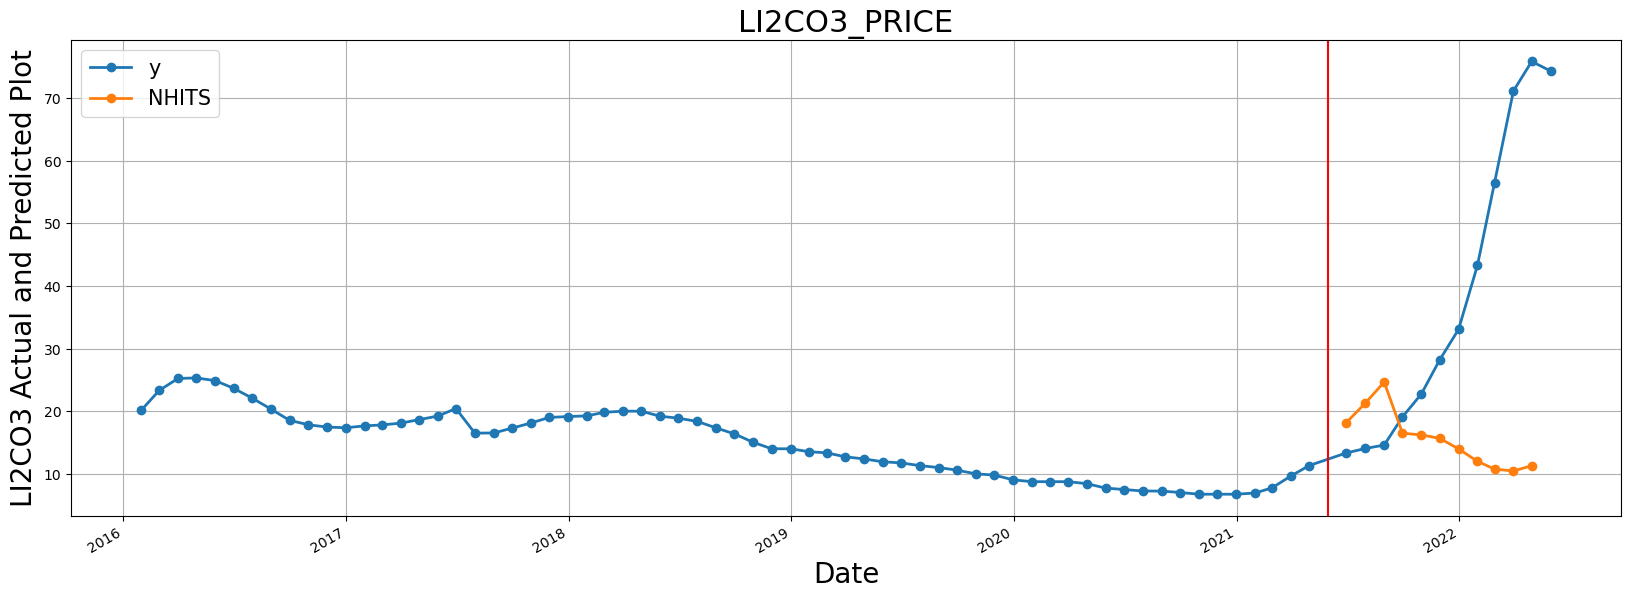

In [242]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
plt.axvline(cutoff_date, color='red')

ax.set_title('LI2CO3_PRICE', fontsize=22)
ax.set_ylabel('LI2CO3 Actual and Predicted Plot', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [243]:
plot_df[['y', 'NHITS']]

,y,NHITS
ds,,
2016-01-31,20.177268,NaN
2016-02-29,23.306868,NaN
2016-03-31,25.223010,NaN
2016-04-30,25.308243,NaN
2016-05-31,24.875099,NaN
...,...,...
2022-01-31,43.260870,12.000559
2022-02-28,56.425000,10.754841
2022-03-31,71.086957,10.456773
